# Micro- (and hopefully soon geo-) Founded Occupational Mobility Network

*Setup from @rmaria del rio-chanona et al. 2021*
*Code: @ebbamark


In [1]:
# Import packages
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import math as math
from scipy.interpolate import splrep, BSpline
import seaborn as sns
from IPython import display
from matplotlib.backends.backend_pdf import PdfPages
rng = np.random.default_rng()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/"

## Setup

### Agents and Classes

Two functions and three classes are defined:
- (Function) Utility/decision-making function used by workers when deciding which vacancies to apply to. Currently this only looks at a wage differential.
- (Function) Search_effort: Search-effort as a function of time spent unemployed - output is the number of vacancies to apply to.
- (Class) Worker: individual worker has state-specific attributes (current or latest held occupation, time unemployed, whether or not long-term unemployed, current or latest wage held, whether or not they have been hired in the current time step, risk aversion score). Additional possible attributes which are for now excluded (occupational history). Worker has one function which is to search and apply for a vacancy.
- (Class) Occupation has an id, list of workers currently employed in that occupation, list of neighboring occupations based on transition adjacency matrix (imperfect solution), current and target demand for labour, list of applicants to open vacancies, and wage). Occupation has two internal functions (1) to separate workers and (2) to update all workers in an occupation after each time step.
- (Class) Vacancy has an occupational id, list of applicants (duplicated above in occupation class...to fix), and a wage (duplicated above in occupation class...to fix). Vacancy has one internal function to hire an applicant.

In [2]:
## Defining functions
# Ranking utility/decision-making function
def util(w_current, w_offered, skill_sim):
    return 1/(1+(math.exp(-((w_offered - w_current)/10000))))

# Simple quadratic for now in which a worker increases search effort for a period of 6 time steps (ie. months) 
# unemployed after which a worker begins to become discouraged. 
# This follows definition from the US BLS and Pew Research Centre
def search_effort(t_unemp):
    return round(20/((t_unemp-6)**2 + 1)) + 1

## Defining classes
# Potentially redundant use of IDs in the below classes...to check
class worker:
    def __init__(wrkr, occupation_id, 
                 # employed, 
                 longterm_unemp, 
                 # time_employed,
                 time_unemployed, wage, hired, risk_av_score):
        # State-specific attributes:
        # Occupation id
        wrkr.occupation_id = occupation_id
        # Binary variable for whether long-term unemployed
        wrkr.longterm_unemp = longterm_unemp
        # Number of time steps unemployed (perhaps redundant with above)
        # Used as criteria for impatience
        wrkr.time_unemployed = time_unemployed
        # Worker wage
        wrkr.wage = wage
        # Whether the worker has been hired in this time step - reset to zero at the end of every time step
        # Used as protective attribute in hiring process (ie. cannot be hired twice in same time step)
        wrkr.hired = hired
        # Additional posible character-specific attributes:
        # Employment history, list of occupations previously held
        # wrkr.emp_history = list_of_occs
        # Identity score - to be defined...
        # wrkr.identity = identity_score
        # Risk aversion: Stefi suggested to use number of 
        # occupations previously held as proxy ie. len(emp_history)
        # Currently takes a value 0-9 indicating at which index of utility ranked vacancies to start sampling/slicing
        wrkr.risk_aversion = risk_av_score
    
    def search_and_apply(wrkr, net, vac_list, beh):
        # A sample of relevant vacancies are found that are in neighboring occupations
        # Will need to add a qualifier in case sample is greater than available relevant vacancies
        rel_vacs = [vac for vac in vac_list if net[wrkr.occupation_id].list_of_neigh_bool[vac.occupation_id]]
        # ^^ have added qualifier...bad form to reassign list?
        if beh:
            rel_vacs = random.sample(rel_vacs, min(len(rel_vacs), 30))
            # Sort found relevant vacancies by utility-function defined above and apply to amount dictated by impatience
            for v in sorted(rel_vacs, key = lambda v: util(wrkr.wage, v.wage,net[wrkr.occupation_id].list_of_neigh_weights[v.occupation_id]), reverse = True)[slice(wrkr.risk_aversion, wrkr.risk_aversion + search_effort(wrkr.time_unemployed))]:
                # Introduce randomness here...?
                v.applicants.append(wrkr)
        else:
            rel_vacs = random.sample(rel_vacs, min(len(rel_vacs), search_effort(wrkr.time_unemployed)))
            for r in rel_vacs:
                r.applicants.append(wrkr)
            
class occupation:
    def __init__(occ, occupation_id, list_of_employed, list_of_unemployed, 
                 list_of_neigh_bool, list_of_neigh_weights, current_demand, 
                 target_demand, wage):
        occ.occupation_id = occupation_id
        occ.list_of_employed = list_of_employed
        occ.list_of_unemployed = list_of_unemployed
        occ.list_of_neigh_bool = list_of_neigh_bool
        occ.list_of_neigh_weights = list_of_neigh_weights
        occ.current_demand = current_demand
        occ.target_demand = target_demand
        occ.wage = wage
    
    def separate_workers(occ, delta_u):
        if(len(occ.list_of_employed) != 0):
            sep_prob = delta_u + gamma * max(0, occ.current_demand - occ.target_demand)/(len(occ.list_of_employed) + 1)
            w = np.random.binomial(len(occ.list_of_employed), sep_prob)
            separated_workers = random.sample(occ.list_of_employed, w)
            occ.list_of_unemployed = occ.list_of_unemployed + separated_workers
            occ.list_of_employed = list(set(occ.list_of_employed) - set(separated_workers))
    
    def update_workers(occ):
        # Possible for loop to replace
        for w in occ.list_of_unemployed:
            w.time_unemployed += 1
            # Chosen 12 months - can be modified
            w.longterm_unemp = True if w.time_unemployed >= 12 else False
            # Possible for loop to replace
        for e in occ.list_of_employed:
            e.hired = False
        
class vac:
    def __init__(v, occupation_id, applicants, wage):
        v.occupation_id = occupation_id
        v.applicants = applicants
        v.wage = wage
        
    # Function to hire a worker from pool of vacancies    
    def hire(v, net):
        a = random.choice(v.applicants)
        assert(not(a.hired))
        net[v.occupation_id].list_of_employed.append(net[a.occupation_id].list_of_unemployed.pop(net[a.occupation_id].list_of_unemployed.index(a)))
        a.occupation_id = v.occupation_id
        a.time_unemployed = 0
        a.wage = v.wage
        #a.emp_history.append(v.occupation_id)
        a.hired = True
        v.applicants.clear()

        
def bus_cycle_demand(d_0, time, amp, period):
    """Business cycle demand equation
    Args:
        d_0: current_demand (emp + vacancies)
        amplitude: amplitude of business cycle # not quite sure what this should be....need to look at the literature
        period: period for full business cycle # I believe this should be between 2-10 years....?
    Returns
        target demand influenced by business cycle
    """
    d_target =  d_0 * (1 - amp * np.sin((2*np.pi / period) * time))
    return d_target

### Data

In [3]:
# Make global decision as to which data to initialise network on. Current options are "toy" or "USA"
init = "toy"
#init = "USA"

# Make global decision about whether to run the model with behavioural components or not
#  this can also be specified in the simulation function below
# behav = False

# Make global decision about whether to run a model with a simulated shock
# For now this is ony incorporated as a simple shock to target demand at one time point - step shift
# need to implement this more carefully and realistically
shock = False

#### Toy Model
Toy model constructed on 5 fake occupations with pre-determined employment, unemployment, vacancies, target demand, and wages.

In [4]:
###################################
# TOY MODEL CONDITIONS AND DATA ###
###################################
if init == "toy":
    T = 1000
    del_u = 0.015
    del_v = 0.009
    gamma_u = gamma_v = gamma = 0.03
    # Import information about relevant files to employment/unemployment, target demand, vacancies, etc.

    A = pd.read_csv(path+"data/small_adj_full.csv", delimiter=';', decimal=',', header=None)
    employment = pd.read_csv(path+"data/employed.csv", header = None)
    unemployment = pd.read_csv(path+"data/unemployed.csv", header = None)
    vacancies = pd.read_csv(path+"data/vacancies.csv", header = None)
    demand_target = employment + vacancies
    wages = pd.DataFrame(np.round(np.random.normal(50000, 10000, 5)), columns = ['Wages'])
    mod_data =  {"A": A, "employment": employment, 
                 'unemployment':unemployment, 'vacancies':vacancies, 
                 'demand_target': demand_target, 'wages': wages}


#### US Model
Model constructed using 464 occupations from US Bureau of Labor Statistics Data and IPUMS.
Data input from replicaiton code in dRC et al 2021: https://zenodo.org/records/4453162


This data should be re-extracted. Perhaps incorporate econometric testing for transition probability/matrix calculations.


In [5]:
###################################
# US MODEL CONDITIONS AND DATA ####
###################################
if init == "USA":
    T = 500
    del_u = 0.015
    del_v = 0.009
    gamma_u = gamma_v = gamma = 0.06

    A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
    employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/1000)
    # Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
    unemployment = round(employment*(0.05/0.95))
    # Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
    vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
    vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
    # Needs input data...
    demand_target = employment + vacancies
    wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
    mod_data =  {"A": A, "employment": employment, 
                 'unemployment':unemployment, 'vacancies':vacancies, 
                 'demand_target': demand_target, 'wages': wages}


### Initialise Network

In [6]:
### Function and condition to initialise network
def initialise(n_occ, employment, unemployment, vacancies, demand_target, A, wages):
    """ Makes a list of occupations with initial conditions
       Args:
           n_occ: number of occupations initialised (464)
           employment: vector with employment of each occupation
           unemployment: vector with unemployment of each occupation
           vacancies: vector with vacancies of each occupation
           demand_target: vector with (initial) target_demand for each occupation (never updated)
           A: adjacency matrix of network (not including auto-transition probability)
           wages: vector of wages of each occupation

       Returns:
            occupations: list of occupations with above attributes
            vacancies: list of vacancies with occupation id, wage, and list of applicants
       """
    occs = []
    vac_list = []
    ids = 0
    for i in range(0, n_occ):
        # appending relevant number of vacancies to economy-wide vacancy list
        for v in range(round(vacancies.iat[i,0])):
            vac_list.append(vac(i, [], wages.iat[i,0]))
            
        occ = occupation(i, [], [], A[i] > 0, A[i],
                         (employment.iat[i,0] + vacancies.iat[i,0]), 
                         demand_target.iat[i,0], wages.iat[i,0])
    
        # creating the workers of occupation i and attaching to occupation
        ## adding employed workers
        for e in range(round(employment.iat[i,0])):
            # Assume they have all at least 1 t.s. of employment
            occ.list_of_employed.append(worker(occ.occupation_id, False, 1, wages.iat[i,0], False, random.randint(0, 9)))
            ## adding unemployed workers
        for u in range(round(unemployment.iat[i,0])):
            # Assigns time unemployed from absolute value of normal distribution....
            occ.list_of_unemployed.append(worker(occ.occupation_id, False, abs(int(np.random.normal(2,5))), wages.iat[i,0], False,
                 
                                                      random.randint(0, 9)))
        occs.append(occ)
        ids += 1
    return occs, vac_list
    

In [7]:
####################
# Testing Cell #####
####################

## Model Run
### Function

In [8]:
####################
# Model Run ########
####################

# Runs a sim

def run_sim(behav_spec, data, time_steps, runs, d_u, d_v):
    """ Runs the model through designated time_steps "runs" times
    Argsuments:
       behav_spec: whether or not to run the behavioural model
       data: data required of initialise function  
       time_steps: Number of time steps for single model run
       runs: Number of simulation runs ie. how many times to run the model
       d_u: parameter input to separation probability
       d_v: parameter input to vacancy opening probability

    Returns:
       dataframe of model run results
    """
    # Records variables of interest for plotting
    record = pd.DataFrame(columns=['Sim', 'Time', 'Occupation_ID', 'Workers', 
                                   'Employment', 'Unemployment', 'Vacancies', 
                                   'LT Unemployed Persons', 'Target_Demand'])
    for run in range(runs):
        print("Running ", init, " model.")
        print("Run: ", run)
        # Initialise occupational mobility network
        net_temp, vacs = initialise(len(data['A']), data['employment'], data['unemployment'], data['vacancies'], data['demand_target'], data['A'], data['wages'])
        for t in range(time_steps):
#             # Shock incorporation....to be changed to dynamic from past applications
#             if t == 400 and shock:
#                 print("initiatied shock!")
#                 net_temp[0].target_demand += 25
#                 net_temp[1].target_demand += 50
#                 net_temp[2].target_demand += 50
#                 net_temp[3].target_demand += 50
#                 net_temp[4].target_demand = 100

            # Ensure number of workers in economy has not changed
            assert(sum(map(lambda x: len(x.list_of_unemployed) + len(x.list_of_employed), net_temp)) == employment.sum().item() + unemployment.sum().item())
            for occ in net_temp:
                # Ensure that separated workers have been reassigned appropriately 
                # (ie. that people move within the same occupation from employed to unemployed 
                # and that the total number of workers within an occupation is (at this stage) 
                # the same as before separations
                if t > 0:
                    temp = record.loc[(record['Sim'] == run) & (record['Occupation_ID'] == occ.occupation_id) & (record['Time'] == t-1)]
                    assert(temp.Employment.item() - len(occ.list_of_employed) ==
                           len(occ.list_of_unemployed) - temp.Unemployment.item())
                    assert(len(occ.list_of_employed) + len(occ.list_of_unemployed) == temp.Workers.item())

                ### APPLICATIONS
                # Questions to verify:
                # - CANNOT be fired and apply in same time step ie. time_unemployed > 0
                # - CAN be rejected and apply in the same time step - no protected attribute
                for u in occ.list_of_unemployed:
                    u.search_and_apply(net_temp, vacs, behav_spec)
                    
                ### SEPARATIONS
                occ.separate_workers(d_u)

            ### HIRING
            # Ordering of hiring randomised to ensure list order does not matter in filling vacancies...
            # Possibly still introduces some bias...this seems to be where the "multiple offer" challenge Maria mentioned comes from
            # ....might be better to do this using an unordered set?
            for v_open in sorted(vacs,key=lambda _: random.random()):
                # Removes any applicants that have already been hired in another vacancy
                v_open.applicants[:] = [app for app in v_open.applicants if not(app.hired)]
                if len(v_open.applicants) > 0:
                    v_open.hire(net_temp)
                    vacs.remove(v_open)
                    assert(len(v_open.applicants) == 0)
                else:
                    pass

            ### OPEN VACANCIES
            # Update vacancies after all shifts have taken place
            # Could consider making this a function of the class itself?
            for occ in net_temp:
                # Update time_unemployed and long-term unemployed status of unemployed workers
                # Remove protected "hired" attribute of employed workers
                occ.update_workers()
                emp = len(occ.list_of_employed)
                occ.current_demand = bus_cycle_demand(len([v_open for v_open in vacs if v_open.occupation_id == occ.occupation_id]) + emp, t, 0.06, 36)
                vac_prob = d_v + ((1 - d_v) * (gamma * max(0, occ.target_demand - occ.current_demand))) / (emp + 1)
                for v in range(int(np.random.binomial(emp, vac_prob))):
                    vacs.append(vac(occ.occupation_id, [], occ.wage))

                ### UPDATE INDICATOR RECORD
                # Record of indicators of interest (simulation number, occ, # workers, employed, unemployed, vacancies, long_term_unemployed)
                record.loc[len(record)]= [run, 
                                          t,
                                          occ.occupation_id,
                                          len(occ.list_of_employed) + len(occ.list_of_unemployed),
                                          len(occ.list_of_employed),
                                          len(occ.list_of_unemployed),
                                          len([v_open for v_open in vacs if v_open.occupation_id == occ.occupation_id]),
                                          sum(wrkr.longterm_unemp for wrkr in occ.list_of_unemployed),
                                          occ.target_demand]

        print("Done after ", t + 1, " time steps.")
    print("Done after ", run + 1, " runs.")
    return(record)


## Results
Current pressing questions:
- How to exhaustively test for parameters delta_u, delta_v, gamma?
- The Beveridge curve relationship is not yet clearly validated....how to best proceed?
- Ideally, we will observe a similar behaviour against the Beveridge curve but not other stylized facts (ie. gender wage gap, unemployment)? How do we get there? Is there cross-validation that needs to be done between the two models first?

In [9]:
# Results specifications (whether to save as final or not)
final = False
fullpdf = False

In [10]:
# Run model without behavioural spec
sim_record_f_all = run_sim(False, mod_data, T, 20, del_u, del_v)
# Run model with behavioural spec
sim_record_t_all = run_sim(True, mod_data, T, 20, del_u, del_v)

sim_record_t = sim_record_t_all.loc[(sim_record_t_all.Time > 0)]
sim_record_f = sim_record_f_all.loc[(sim_record_f_all.Time > 0)]

# Retain one single simulation as minimal example
record1_t = sim_record_t.loc[(sim_record_t.Sim == 0)]
record1_f = sim_record_f.loc[(sim_record_f.Sim == 0)]

Running  toy  model.
Run:  0
Done after  1000  time steps.
Running  toy  model.
Run:  1
Done after  1000  time steps.
Running  toy  model.
Run:  2
Done after  1000  time steps.
Running  toy  model.
Run:  3
Done after  1000  time steps.
Running  toy  model.
Run:  4
Done after  1000  time steps.
Running  toy  model.
Run:  5
Done after  1000  time steps.
Running  toy  model.
Run:  6
Done after  1000  time steps.
Running  toy  model.
Run:  7
Done after  1000  time steps.
Running  toy  model.
Run:  8
Done after  1000  time steps.
Running  toy  model.
Run:  9
Done after  1000  time steps.
Running  toy  model.
Run:  10
Done after  1000  time steps.
Running  toy  model.
Run:  11
Done after  1000  time steps.
Running  toy  model.
Run:  12
Done after  1000  time steps.
Running  toy  model.
Run:  13
Done after  1000  time steps.
Running  toy  model.
Run:  14
Done after  1000  time steps.
Running  toy  model.
Run:  15
Done after  1000  time steps.
Running  toy  model.
Run:  16
Done after  1000  ti

#### Beveridge curve validation

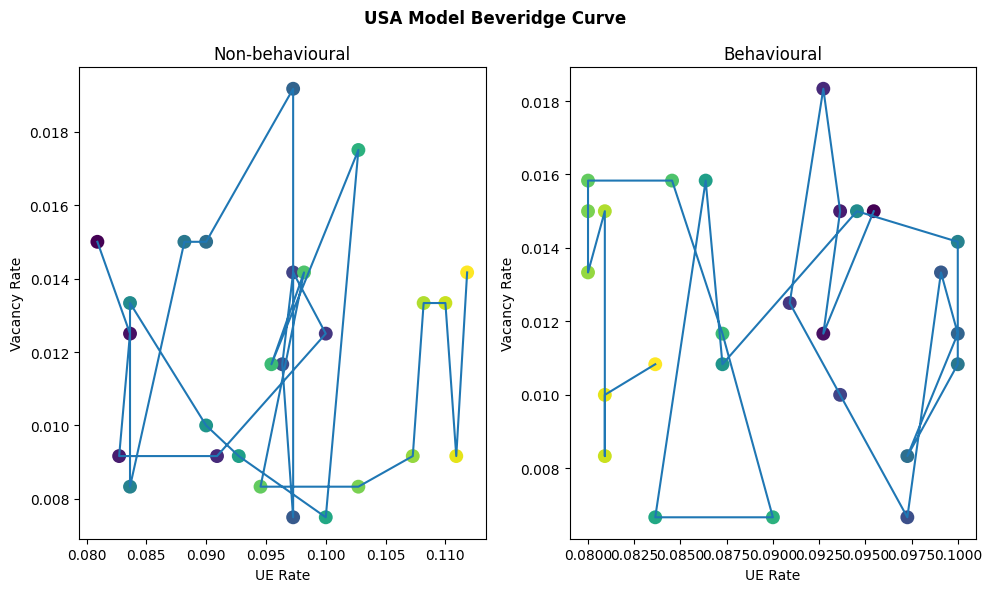

In [11]:
ue_vac_f = record1_f.loc[:,['Time', 'Workers', 'Unemployment', 'Vacancies', 'Target_Demand']].groupby(['Time']).sum().reset_index()
ue_vac_f['UE Rate'] = ue_vac_f['Unemployment'] / ue_vac_f['Workers']
ue_vac_f['Vac Rate'] = ue_vac_f['Vacancies'] / ue_vac_f['Target_Demand']
ue_vac_f = ue_vac_f.loc[(ue_vac_f.Time > 300) & (ue_vac_f.Time < 327)]

ue_vac_t = record1_t.loc[:,['Time', 'Workers', 'Unemployment', 'Vacancies', 'Target_Demand']].groupby(['Time']).sum().reset_index()
ue_vac_t['UE Rate'] = ue_vac_t['Unemployment'] / ue_vac_t['Workers']
ue_vac_t['Vac Rate'] = ue_vac_t['Vacancies'] / ue_vac_t['Target_Demand']
ue_vac_t = ue_vac_t.loc[(ue_vac_t.Time > 300) & (ue_vac_t.Time < 327)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.plot(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'])
ax1.scatter(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], c=ue_vac_f['Time'], s=100, lw=0)
ax1.set_title("Non-behavioural")
ax1.set_xlabel("UE Rate")
ax1.set_ylabel("Vacancy Rate")

ax2.plot(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'])
ax2.set_title("Behavioural")
ax2.scatter(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], c=ue_vac_t['Time'], s=100, lw=0)
ax2.set_xlabel("UE Rate")
ax2.set_ylabel("Vacancy Rate")

    
fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
fig.tight_layout()

if final:
    plt.savefig('../output/overall_economy_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()

#### Overall Economy: Employment, Unemployment, Worker, Vacancy, and Longterm Employed Levels

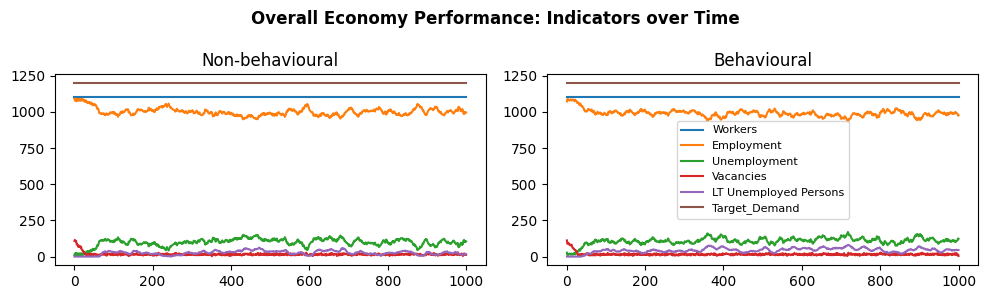

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

totals = record1_f.loc[:,['Time', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
lgd = []
for column in totals[1:]:
    ax1.plot(totals[column])
    lgd.append(column)
ax1.set_title("Non-behavioural")
    
totals = record1_t.loc[:,['Time', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
for column in totals[1:]:
    ax2.plot(totals[column])
ax2.set_title('Behavioural')

fig.suptitle("Overall Economy Performance: Indicators over Time", fontweight = 'bold')
plt.legend(list(lgd), loc="center", ncol=1, fontsize = 8)
fig.tight_layout()

if final:
    plt.savefig('../output/overall_economy_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()

#### Long-term unemployment rate and levels


In [13]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
# colors = colors = ['b','g','r','y','m']

# sim_record_f['UE Rate'] = sim_record_f['Unemployment'] / sim_record_f['Workers']
# for o in np.unique(sim_record_f.Occupation_ID):
#     temp = sim_record_f[(sim_record_f['Occupation_ID'] == o)][['UE Rate', 'Time', 'Sim']]
#     temp_mean = temp.loc[:, ['Time', 'UE Rate']].groupby(['Time']).mean().reset_index()
#     spl = splrep(temp_mean['Time'], temp_mean['UE Rate'], s=2)
#     for g in np.unique(temp.Sim):
#         ax1.plot(temp[(temp['Sim'] == g)]['Time'], temp[(temp['Sim'] == g)]['UE Rate'], alpha = 0.05, color = colors[o])
#     ax1.plot(temp_mean['Time'], BSpline(*spl)(temp_mean['Time']), '-', color = colors[o])
# ax1.set_title("Non-behavioural")
# fig.suptitle("Unemployment Rate", fontweight = 'bold')

# sim_record_t['UE Rate'] = sim_record_t['Unemployment'] / sim_record_t['Workers']
# for o in np.unique(sim_record_t.Occupation_ID):
#     temp = sim_record_t[(sim_record_t['Occupation_ID'] == o)][['UE Rate', 'Time', 'Sim']]
#     temp_mean = temp.loc[:, ['Time', 'UE Rate']].groupby(['Time']).mean().reset_index()
#     spl = splrep(temp_mean['Time'], temp_mean['UE Rate'], s=3)
#     for g in np.unique(temp.Sim):
#         ax2.plot(temp[(temp['Sim'] == g)]['Time'], temp[(temp['Sim'] == g)]['UE Rate'], alpha = 0.05, color = colors[o])
#     ax2.plot(temp_mean['Time'], BSpline(*spl)(temp_mean['Time']), '-', color = colors[o])
# ax2.set_title("Behavioural")
# fig.suptitle("Unemployment Rate by Occupation", fontweight = 'bold')
# fig.tight_layout()

#### Occupations: Employment, Unemployment, Worker, Vacancy, and Longterm Unemployed Levels

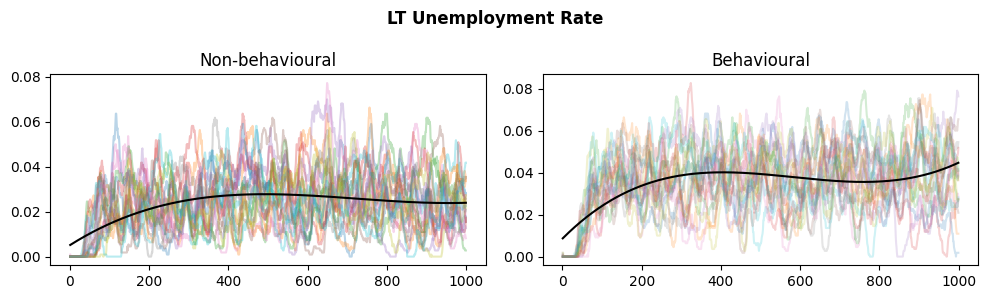

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ltue_tot = sim_record_f.loc[:,['Sim','Time', 'Workers', 'Unemployment', 'LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time', 'LTUE Rate']].groupby(['Time']).mean().reset_index()
spl = splrep(ltue_mean['Time'], ltue_mean['LTUE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time']]
    ax1.plot(temp['Time'], temp['LTUE Rate'], alpha = 0.3)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax1.plot(temp['Time'], temp['UE Rate'])
ax1.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
ax1.set_title("Non-behavioural")
fig.suptitle("LT Unemployment Rate", fontweight = 'bold')


ltue_tot = sim_record_t.loc[:,['Sim','Time', 'Workers', 'Unemployment','LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time', 'LTUE Rate']].groupby(['Time']).mean().reset_index()
spl = splrep(ltue_mean['Time'], ltue_mean['LTUE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time']]
    ax2.plot(temp['Time'], temp['LTUE Rate'], alpha = 0.2)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax2.plot(temp['Time'], temp['UE Rate'])
ax2.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
ax2.set_title("Behavioural")
fig.suptitle("LT Unemployment Rate", fontweight = 'bold')
fig.tight_layout()

if final:
    plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()

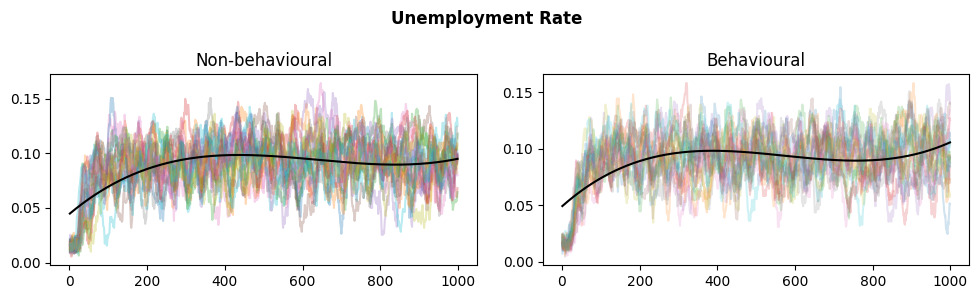

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ltue_tot = sim_record_f.loc[:,['Sim','Time', 'Workers', 'Unemployment', 'LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time', 'UE Rate']].groupby(['Time']).mean().reset_index()
spl = splrep(ltue_mean['Time'], ltue_mean['UE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    ax1.plot(temp['Time'], temp['UE Rate'], alpha = 0.3)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax1.plot(temp['Time'], temp['UE Rate'])
ax1.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
ax1.set_title("Non-behavioural")
fig.suptitle("Unemployment Rate", fontweight = 'bold')


ltue_tot = sim_record_t.loc[:,['Sim','Time', 'Workers', 'Unemployment','LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
ltue_mean = ltue_tot.loc[:, ['Time', 'UE Rate']].groupby(['Time']).mean().reset_index()
spl = splrep(ltue_mean['Time'], ltue_mean['UE Rate'], s=2)
for g in np.unique(ltue_tot.Sim):
    temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    ax2.plot(temp['Time'], temp['UE Rate'], alpha = 0.2)
    #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
    #ax2.plot(temp['Time'], temp['UE Rate'])
ax2.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
ax2.set_title("Behavioural")
fig.suptitle("Unemployment Rate", fontweight = 'bold')
fig.tight_layout()

if final:
    plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
else:
    plt.show()
plt.close()

#### Optional plot saving code for saving to pdf

In [16]:
# with PdfPages('multipage_us_k.pdf') as pdf:
#     for del_u in [0.005]:#δ_u_list:
#         for del_v in [0.01]: #δ_v_list:
#                 gamma = 10*del_u
#                 print(["δ_u: " + str(del_u) + "; δ_v: " + str(del_v)])
#                 sim_record_f_all = run_sim(False, mod_data, T, 1, del_u, del_v)
#                 sim_record_t_all = run_sim(True, mod_data, T, 1, del_u, del_v)
#                 sim_record_t = sim_record_t_all.loc[(sim_record_t_all.Time > 0)]
#                 sim_record_f = sim_record_f_all.loc[(sim_record_f_all.Time > 0)]
#                 record1_f = sim_record_f.loc[(sim_record_f.Sim == 0)]
#                 record1_t = sim_record_t.loc[(sim_record_t.Sim == 0)]

#                 txt = ["δ_u: " + str(del_u) + "; δ_v: " + str(del_v)]
#                 ue_vac_f = record1_f.loc[:,['Time', 'Workers', 'Unemployment', 'Vacancies', 'Target_Demand']].groupby(['Time']).sum().reset_index()
#                 ue_vac_f['UE Rate'] = ue_vac_f['Unemployment'] / ue_vac_f['Workers']
#                 ue_vac_f['Vac Rate'] = ue_vac_f['Vacancies'] / ue_vac_f['Target_Demand']
#                 ue_vac_f = ue_vac_f.loc[(ue_vac_f.Time > 300) & (ue_vac_f.Time < 327)]

#                 ue_vac_t = record1_t.loc[:,['Time', 'Workers', 'Unemployment', 'Vacancies', 'Target_Demand']].groupby(['Time']).sum().reset_index()
#                 ue_vac_t['UE Rate'] = ue_vac_t['Unemployment'] / ue_vac_t['Workers']
#                 ue_vac_t['Vac Rate'] = ue_vac_t['Vacancies'] / ue_vac_t['Target_Demand']
#                 ue_vac_t = ue_vac_t.loc[(ue_vac_t.Time > 300) & (ue_vac_t.Time < 327)]


#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

#                 ax1.plot(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'])
#                 ax1.scatter(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], c=ue_vac_f['Time'], s=100, lw=0)
#                 ax1.set_title("Non-behavioural")
#                 ax1.set_xlabel("UE Rate")
#                 ax1.set_ylabel("Vacancy Rate")

#                 ax2.plot(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'])
#                 ax2.set_title("Behavioural")
#                 ax2.scatter(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], c=ue_vac_t['Time'], s=100, lw=0)
#                 ax2.set_xlabel("UE Rate")
#                 ax2.set_ylabel("Vacancy Rate")

#                 fig.text(0.05,0.95,txt, transform=fig.transFigure, size=18)
#                 fig.suptitle("Beveridge Curve", fontweight = 'bold')
#                 fig.tight_layout()


#                 if final:
#                     plt.savefig('../output/overall_economy_comparison_behav.jpg', dpi = 300)
#                 elif fullpdf:
#                     pdf.savefig()
#                     plt.close()
#                 else:
#                     plt.show()


#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

#                 totals = record1_f.loc[:,['Time', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
#                 lgd = []
#                 for column in totals[1:]:
#                     ax1.plot(totals[column])
#                     lgd.append(column)
#                 ax1.set_title("Non-behavioural")

#                 totals = record1_t.loc[:,['Time', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
#                 for column in totals[1:]:
#                     ax2.plot(totals[column])
#                 ax2.set_title('Behavioural')

#                 fig.suptitle("Overall Economy Performance: Indicators over Time", fontweight = 'bold')
#                 plt.legend(list(lgd), loc="center", ncol=1, fontsize = 8)
#                 fig.tight_layout()

#                 if final:
#                     plt.savefig('../output/overall_economy_comparison_behav.jpg', dpi = 300)
#                 elif fullpdf:
#                     pdf.savefig()
#                     plt.close()
#                 else:
#                     plt.show()

#                 #### Occupations: Employment, Unemployment, Worker, Vacancy, and Longterm Unemployed Levels
#                 # # Overall indicators per occupation
#                 # ids = np.unique(record1_t.Occupation_ID)
#                 # fig = plt.figure(constrained_layout = False)

#                 # occ_totals = record1_t.loc[:,['Time', 'Occupation_ID', 'Workers','Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']]
#                 # for occ in ids:
#                 #     gtmp = occ_totals[(occ_totals['Occupation_ID'] == occ)].loc[:, ['Time', 'Workers', 'Employment', 'Unemployment', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']].groupby(['Time']).sum()
#                 #     # Indicators (workers, employment, etc)
#                 #     fig.add_subplot(3, 2, int(occ)+1, title = f'Occ: {int(occ)}')
#                 #     lgd = []
#                 #     for column in gtmp[1:]:
#                 #         plt.plot(gtmp[column])
#                 #         lgd.append(column)

#                 # fig.suptitle("Economy Performance per Economy: Indicators over Time", fontweight = 'bold')
#                 # fig.legend(list(lgd), bbox_to_anchor=(0.9, 0.3), ncols = 1, title_fontsize = "6", fontsize="8")
#                 # fig.subplots_adjust(wspace=0.2, hspace = 0.75)
#                 # if final:
#                 #     plt.savefig('../output/occ_perf_base.jpg', dpi = 300)
#                 # else:
#                 #     plt.show()
#                 # plt.close(fig)
#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

#                 ltue_tot = sim_record_f.loc[:,['Sim','Time', 'Workers', 'Unemployment', 'LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
#                 ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
#                 ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
#                 ltue_mean = ltue_tot.loc[:, ['Time', 'LTUE Rate']].groupby(['Time']).mean().reset_index()
#                 spl = splrep(ltue_mean['Time'], ltue_mean['LTUE Rate'], s=2)
#                 for g in np.unique(ltue_tot.Sim):
#                     temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time']]
#                     ax1.plot(temp['Time'], temp['LTUE Rate'], alpha = 0.3)
#                     #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     #ax1.plot(temp['Time'], temp['UE Rate'])
#                 ax1.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
#                 ax1.set_title("Non-behavioural")
#                 fig.suptitle("LT Unemployment Rate", fontweight = 'bold')


#                 ltue_tot = sim_record_t.loc[:,['Sim','Time', 'Workers', 'Unemployment','LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
#                 ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
#                 ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
#                 ltue_mean = ltue_tot.loc[:, ['Time', 'LTUE Rate']].groupby(['Time']).mean().reset_index()
#                 spl = splrep(ltue_mean['Time'], ltue_mean['LTUE Rate'], s=2)
#                 for g in np.unique(ltue_tot.Sim):
#                     temp = ltue_tot[(ltue_tot['Sim'] == g)][['LTUE Rate', 'Time']]
#                     ax2.plot(temp['Time'], temp['LTUE Rate'], alpha = 0.2)
#                     #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     #ax2.plot(temp['Time'], temp['UE Rate'])
#                 ax2.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
#                 ax2.set_title("Behavioural")
#                 fig.suptitle("LT Unemployment Rate", fontweight = 'bold')
#                 fig.tight_layout()

#                 if final:
#                     plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
#                 elif fullpdf:
#                     pdf.savefig()
#                     plt.close()
#                 else:
#                     plt.show()


#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

#                 ltue_tot = sim_record_f.loc[:,['Sim','Time', 'Workers', 'Unemployment', 'LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
#                 ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
#                 ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
#                 ltue_mean = ltue_tot.loc[:, ['Time', 'UE Rate']].groupby(['Time']).mean().reset_index()
#                 spl = splrep(ltue_mean['Time'], ltue_mean['UE Rate'], s=2)
#                 for g in np.unique(ltue_tot.Sim):
#                     temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     ax1.plot(temp['Time'], temp['UE Rate'], alpha = 0.3)
#                     #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     #ax1.plot(temp['Time'], temp['UE Rate'])
#                 ax1.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
#                 ax1.set_title("Non-behavioural")
#                 fig.suptitle("Unemployment Rate", fontweight = 'bold')


#                 ltue_tot = sim_record_t.loc[:,['Sim','Time', 'Workers', 'Unemployment','LT Unemployed Persons']].groupby(['Time', 'Sim']).sum().reset_index()
#                 ltue_tot['UE Rate'] = ltue_tot['Unemployment'] / ltue_tot['Workers']
#                 ltue_tot['LTUE Rate'] = ltue_tot['LT Unemployed Persons'] / ltue_tot['Workers']
#                 ltue_mean = ltue_tot.loc[:, ['Time', 'UE Rate']].groupby(['Time']).mean().reset_index()
#                 spl = splrep(ltue_mean['Time'], ltue_mean['UE Rate'], s=2)
#                 for g in np.unique(ltue_tot.Sim):
#                     temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     ax2.plot(temp['Time'], temp['UE Rate'], alpha = 0.2)
#                     #temp = ltue_tot[(ltue_tot['Sim'] == g)][['UE Rate', 'Time']]
#                     #ax2.plot(temp['Time'], temp['UE Rate'])
#                 ax2.plot(ltue_mean['Time'], BSpline(*spl)(ltue_mean['Time']), '-', label='s=0',  color = 'black')
#                 ax2.set_title("Behavioural")
#                 fig.suptitle("Unemployment Rate", fontweight = 'bold')
#                 fig.tight_layout()

#                 if final:
#                     plt.savefig('../output/ltuer_sim_comparison_behav.jpg', dpi = 300)
#                 elif fullpdf:
#                     pdf.savefig()
#                     plt.close()
#                 else:
#                     plt.show()